## Convert SMILES->Graph (G=(V,E))
ref.: https://www.rdkit.org/docs/GettingStartedInPython.html#working-with-molecules

In [12]:
import pandas as pd
import pickle
from rdkit import Chem
from tqdm import tqdm

# Your SMILES-to-graph converter
def smiles_to_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    nodes = [atom.GetAtomicNum() for atom in mol.GetAtoms()]
    edges = []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        edges.append((i, j))
        edges.append((j, i))  # undirected

    return nodes, edges


df = pd.read_csv("Odor_SMILES.csv", encoding='ISO-8859-1')

# Store results as list of dicts
graph_data = []

for idx, row in tqdm(df.iterrows(), total=len(df)):
    smiles = row['SMILES']
    cas = row['cas_number']

    if pd.isna(smiles) or smiles.strip() == "":
        continue

    graph = smiles_to_graph(smiles)
    if graph is not None:
        nodes, edges = graph
        graph_data.append({
            "cas_number": cas,
            "smiles": smiles,
            "nodes": nodes,
            "edges": edges
        })

# Save to a file
with open("graph_data.pkl", "wb") as f:
    pickle.dump(graph_data, f)

print(f"Saved {len(graph_data)} valid molecular graphs to graph_data.pkl")


  0%|          | 0/3837 [00:00<?, ?it/s][15:09:53] WARNING: not removing hydrogen atom without neighbors
[15:09:53] WARNING: not removing hydrogen atom without neighbors
100%|██████████| 3837/3837 [00:00<00:00, 5215.47it/s]

Saved 3051 valid molecular graphs to graph_data.pkl


In [13]:
smiles = "C/C=C/C(=O)C1=C(C)C=CCC1(C)C"
mol = Chem.MolFromSmiles(smiles)

# Atoms
for atom in mol.GetAtoms():
    print(f"Atom idx: {atom.GetIdx()}, Symbol: {atom.GetSymbol()}, AtomicNum: {atom.GetAtomicNum()}")

# Bonds
for bond in mol.GetBonds():
    print(f"Bond: {bond.GetBeginAtomIdx()} - {bond.GetEndAtomIdx()}, Type: {bond.GetBondType()}")


Atom idx: 0, Symbol: C, AtomicNum: 6
Atom idx: 1, Symbol: C, AtomicNum: 6
Atom idx: 2, Symbol: C, AtomicNum: 6
Atom idx: 3, Symbol: C, AtomicNum: 6
Atom idx: 4, Symbol: O, AtomicNum: 8
Atom idx: 5, Symbol: C, AtomicNum: 6
Atom idx: 6, Symbol: C, AtomicNum: 6
Atom idx: 7, Symbol: C, AtomicNum: 6
Atom idx: 8, Symbol: C, AtomicNum: 6
Atom idx: 9, Symbol: C, AtomicNum: 6
Atom idx: 10, Symbol: C, AtomicNum: 6
Atom idx: 11, Symbol: C, AtomicNum: 6
Atom idx: 12, Symbol: C, AtomicNum: 6
Atom idx: 13, Symbol: C, AtomicNum: 6
Bond: 0 - 1, Type: SINGLE
Bond: 1 - 2, Type: DOUBLE
Bond: 2 - 3, Type: SINGLE
Bond: 3 - 4, Type: DOUBLE
Bond: 3 - 5, Type: SINGLE
Bond: 5 - 6, Type: DOUBLE
Bond: 6 - 7, Type: SINGLE
Bond: 6 - 8, Type: SINGLE
Bond: 8 - 9, Type: DOUBLE
Bond: 9 - 10, Type: SINGLE
Bond: 10 - 11, Type: SINGLE
Bond: 11 - 12, Type: SINGLE
Bond: 11 - 13, Type: SINGLE
Bond: 11 - 5, Type: SINGLE


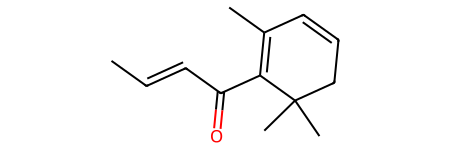

In [15]:
m = Chem.MolFromSmiles('C/C=C/C(=O)C1=C(C)C=CCC1(C)C')
m

In [ ]:
# Helper function for one-hot encoding
def one_hot_encode(values, unique_values):
    # Create a zero tensor of size equal to the number of unique values
    one_hot_tensor = torch.zeros(len(values), len(unique_values))
    
    # Set the appropriate index to 1 for each value
    for i, value in enumerate(values):
        index = unique_values.index(value)
        one_hot_tensor[i][index] = 1
    return one_hot_tensor

In [33]:
from typing import Any
import torch
import torch_geometric
from rdkit import Chem, RDLogger
from torch_geometric.data import Data
from rdkit.Chem import Descriptors
from rdkit.Chem import Lipinski
import pandas as pd
RDLogger.DisableLog('rdApp.*')

x_map = {
    'atomic_num':
    list(range(0, 119)),
    'chirality': [
        'CHI_UNSPECIFIED',
        'CHI_TETRAHEDRAL_CW',
        'CHI_TETRAHEDRAL_CCW',
        'CHI_OTHER',
        'CHI_TETRAHEDRAL',
        'CHI_ALLENE',
        'CHI_SQUAREPLANAR',
        'CHI_TRIGONALBIPYRAMIDAL',
        'CHI_OCTAHEDRAL',
    ],
    'valence':
    list(range(0,6)),
    'degree':
    list(range(0, 11)),
    'formal_charge':
    list(range(-5, 7)),
    'num_hs':
    list(range(0, 9)),
    'num_radical_electrons':
    list(range(0, 5)),
    'hybridization': [
        'UNSPECIFIED',
        'S',
        'SP',
        'SP2',
        'SP3',
        'SP3D',
        'SP3D2',
        'OTHER',
    ],
    'is_aromatic': [False, True],
    'is_in_ring': [False, True],
    'smallest_ring':
    list(range(0, 20)),
    'bond_types_connected':[
        'UNSPECIFIED',
        'SINGLE',
        'DOUBLE',
        'TRIPLE',
        'QUADRUPLE',
        'QUINTUPLE',
        'HEXTUPLE',
        'ONEANDAHALF',
        'TWOANDAHALF',
        'THREEANDAHALF',
        'FOURANDAHALF',
        'FIVEANDAHALF',
        'AROMATIC',
        'IONIC',
        'HYDROGEN',
        'THREECENTER',
        'DATIVEONE',
        'DATIVE',
        'DATIVEL',
        'DATIVER',
        'OTHER',
        'ZERO',
    ]
}

e_map = {
    'stereo': [
        'STEREONONE',
        'STEREOANY',
        'STEREOZ',
        'STEREOE',
        'STEREOCIS',
        'STEREOTRANS',
    ],
    'is_conjugated': [False, True],

}

mol_map = {
    'molecular_weight': [0],  # This could be a single scalar value
    'logp': [0],              # This is a scalar value
    'tpsa': [0],              # Topological Polar Surface Area (scalar)
    'num_rings': list(range(0, 21)),  # Range for the number of rings in the molecule
    'num_rotatable_bonds': list(range(0, 11)),  # Number of rotatable bonds
}

# Featurization function
def from_smiles(smiles: str, with_hydrogen: bool = False,
                kekulize: bool = False) -> 'torch_geometric.data.Data':
    r"""Converts a SMILES string to a :class:`torch_geometric.data.Data`
    instance.

    Args:
        smiles (str): The SMILES string.
        with_hydrogen (bool, optional): If set to :obj:`True`, will store
            hydrogens in the molecule graph. (default: :obj:`False`)
        kekulize (bool, optional): If set to :obj:`True`, converts aromatic
            bonds to single/double bonds. (default: :obj:`False`)
    """
    try:
        mol = Chem.MolFromSmiles(smiles)

        if mol is None:
            print(f"Failed to parse SMILES: {smiles}")
            return None
        if with_hydrogen:
            mol = Chem.AddHs(mol)
        if kekulize:
            Chem.Kekulize(mol)

        # Extract node features
        node_features= []
        for atom in mol.GetAtoms():
            atomic_num = atom.GetAtomicNum()
            valence = atom.GetTotalValence()
            degree = atom.GetTotalDegree()
            num_hs = atom.GetTotalNumHs()
            num_radical_electrons= atom.GetNumRadicalElectrons()
            formal_charge = atom.GetFormalCharge()
            chirality = atom.GetChiralTag()
            hybridization = atom.GetHybridization()
            is_aromatic = atom.GetIsAromatic()
            in_ring = atom.IsInRing()

            # Get the ring size (smallest size if the atom is part of multiple rings)
            ring_sizes = [ring_size for ring_size in range(3, 9) if atom.IsInRingSize(ring_size)]
            smallest_ring = min(ring_sizes) if ring_sizes else 0

            # Get the types of bonds this atom is involved in
            bond_types_connected = set()
            for bond in atom.GetBonds():
                bond_types_connected.add(str(bond.GetBondType()))

            # Encode features for the atom
            features = [
                atomic_num,           # atomic number
                chirality,            # chirality
                degree,               # degree
                formal_charge,        # formal charge
                num_hs,               # number of hydrogens
                num_radical_electrons, # number radical electrons
                valence,              # valence
                hybridization,        # hybridization
                is_aromatic,          # aromatic
                in_ring,              # is in ring
                smallest_ring,        # ring size
                len(bond_types_connected),      # number of bond types connected
            ]

            # Add the features of the atom to the node list
            node_features.append(features)

        if not node_features:
            print(f"[Warning] No atoms found in: {smiles}")
            return None

        node_features = torch.tensor(node_features, dtype=torch.float)
        
        # Extract edge features
        edge_indices, edge_attrs = [], []
        for bond in mol.GetBonds():
            i = bond.GetBeginAtomIdx()
            j = bond.GetEndAtomIdx()

            stereo = str(bond.GetStereo())
            stereo_idx = e_map['stereo'].index(stereo) if stereo in e_map['stereo'] else e_map['stereo'].index('STEREONONE')

            e = [
                stereo_idx,
                e_map['is_conjugated'].index(bond.GetIsConjugated()),
            ]

            edge_indices += [[i, j], [j, i]]
            edge_attrs += [e, e]

        #Convert edge to tensor
        edge_index = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()
        edge_attr = torch.tensor(edge_attrs, dtype=torch.long)

        if edge_index.numel() > 0:  # Sort indices.
            perm = (edge_index[0] * node_features.size(0) + edge_index[1]).argsort()
            edge_index, edge_attr = edge_index[:, perm], edge_attr[perm]

        # Extract Molecular features
        mol_features = {
            'mol_weight': Descriptors.MolWt(mol),
            'logP': Descriptors.MolLogP(mol),
            'TPSA': Descriptors.TPSA(mol),
            'num_rings': len(mol.GetRingInfo().AtomRings()),
            'num_rotatable_bonds': Lipinski.NumRotatableBonds(mol),
        }

        mol_tensor = torch.tensor(list(mol_features.values()), dtype=torch.float)

        # Create the graph object for PyG
        data= Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr, smiles=smiles)
        data.mol_features = mol_tensor

        return data
        
    except Exception as e:
        print(f"[Error] Failed to process SMILES: {smiles} — {e}")
        return None


In [34]:
# Load the CSV file containing SMILES strings
df = pd.read_csv('OdorSmiles_Updated.csv', encoding='ISO-8859-1')  # Update with your file path
output_path = "smiles_features_output.txt"

with open(output_path, "w") as f:
    # Loop through each SMILES in the CSV
    for index, row in df.iterrows():
        smiles = row['SMILES']  # Assuming the column containing SMILES is named 'smiles'
        
        # Get the features for each molecule
        data = from_smiles(smiles)

        f.write(f"\nFeatures for SMILES: {smiles}\n")
        f.write("-" * 60 + "\n")
        
        if data is not None:
        
            f.write("Node Feature Matrix:\n")
            f.write(str(data.x) + "\n\n")

            f.write("Molecular Features:\n")
            f.write(str(data.mol_features) + "\n\n")

            f.write("=" * 80 + "\n")
        else:
            print(f"Failed to process SMILES: {smiles}")

print(f"Output saved to: {output_path}")

[Error] Failed to process SMILES: nan — No registered converter was able to produce a C++ rvalue of type class std::basic_string<wchar_t,struct std::char_traits<wchar_t>,class std::allocator<wchar_t> > from this Python object of type float
Failed to process SMILES: nan
[Error] Failed to process SMILES: nan — No registered converter was able to produce a C++ rvalue of type class std::basic_string<wchar_t,struct std::char_traits<wchar_t>,class std::allocator<wchar_t> > from this Python object of type float
Failed to process SMILES: nan
[Error] Failed to process SMILES: nan — No registered converter was able to produce a C++ rvalue of type class std::basic_string<wchar_t,struct std::char_traits<wchar_t>,class std::allocator<wchar_t> > from this Python object of type float
Failed to process SMILES: nan
[Error] Failed to process SMILES: nan — No registered converter was able to produce a C++ rvalue of type class std::basic_string<wchar_t,struct std::char_traits<wchar_t>,class std::allocator